In [1]:
import numpy as np
import pandas as pd
import copy
import time
import re
import collections
from datetime import datetime, timedelta
import os
from tqdm import tqdm
import matplotlib.pyplot as plt
import sys
to_timestamp = lambda s: np.int64(time.mktime(datetime.strptime(str(s), "%Y-%m-%d %H:%M:%S").timetuple()))

sys.path.append("..")
from utils.tools import df_analyze

/home/kelon/anaconda3/envs/CVD/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [1]:
rootdir = "../Multi_data/"
ts_data = 'P18'
text_data = 'ECER'
data_name = ts_data + '_' + text_data + '/'
datapath = rootdir + data_name

In [3]:
df_label = pd.read_csv(datapath + 'df_outcomes.csv', low_memory=False,)

In [8]:
train, val, test = np.load(datapath + 'splits/1_fold.npy',
                           allow_pickle=True)
print(len(train), len(val), len(test))

46036 2558 2557


In [8]:
train_label = df_label.iloc[train]
val_label = df_label.iloc[val]
test_label = df_label.iloc[test]

In [4]:
df_label.head()

,RecordID,PatientID,Length_of_stay,Death,Cvd,ICD
0,100001,58526,149,0,0,0
1,100003,54610,98,0,0,0
2,100006,9895,289,0,0,0
3,100007,23018,175,0,0,0
4,100009,533,118,0,1,414.8-411.1-414.01-414.2


In [9]:
df_analyze(df_label)

,Column,null,unique,type
0,RecordID,0,51151,int64
1,PatientID,0,40844,int64
2,Length_of_stay,0,1894,int64
3,Death,0,2,int64
4,Cvd,0,2,int64
5,ICD,0,1470,object


In [8]:
max(df_label.Length_of_stay.values)

7072

(0, 48]         3612
(48, 96]        7775
(96, 144]       9456
(144, 192]      7537
(192, 240]      5308
(240, 288]      3634
(288, 336]      2637
(336, 384]      2004
(384, 432]      1525
(432, 480]      1178
(480, 528]      1011
(528, 576]       792
(576, 624]       627
(624, 672]       521
(672, 720]       477
(720, 768]       353
(768, 816]       274
(816, 864]       299
(864, 912]       211
(912, 960]       198
(960, 1008]      178
(1008, 1056]     144
(1056, 1104]     123
(1104, 1152]     103
(1152, 1200]      93
(1200, 1248]      90
(1248, 1296]      80
(1296, 1344]      70
(1344, 1392]      73
(1392, 1440]      53
(1440, 1488]      47
dtype: int64


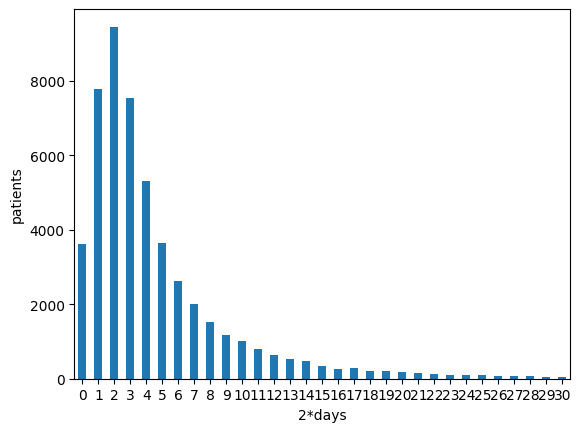

In [5]:
# 大部分病人的住院时长在25天内
s = pd.cut(df_label.Length_of_stay.values, bins=[i for i in range(0, 1500, 48)])
print(s.value_counts())
values = s.value_counts().values
df = pd.DataFrame(values)
df.plot(kind='bar', legend=False)
plt.xticks(rotation=0)
plt.ylabel('patients')
plt.xlabel('2*days')
plt.show()

In [12]:
def func1(df):
    days = df.Length_of_stay.values
    days = sorted(days)
    length = len(days)
    ave = np.mean(days) / 24
    mid = days[length//2] / 24
    rate = len(df[df.Cvd==1]) / length
    print(length, rate, ave, mid)

In [13]:
for df in [train_label, val_label, test_label]:
    func1(df)

46036 0.382135719871405 11.024561393981521 7.208333333333333
2558 0.388975762314308 11.15114347146208 7.291666666666667
2557 0.3805240516229957 11.387628731586496 7.083333333333333


In [14]:
46035+1558+2557

50150

### Chartevents可视化

In [4]:
# 展示每份记录不同时间点的数量
P_list = np.load(datapath + 'P_list.npy', allow_pickle=True)
ts_params = np.load(datapath + 'ts_params.npy', allow_pickle=True)
static_params = np.load(datapath + 'static_params.npy', allow_pickle=True)

n = len(P_list)
max_tmins = 240*60
len_ts = []

for ind in tqdm(range(n)):  # for each record
    ts = P_list[ind]['ts']
    unq_tmins = []
    for sample in ts:  # for each instance (time point)
        current_tmin = sample[2]
        if (current_tmin not in unq_tmins) and (current_tmin < max_tmins):
            unq_tmins.append(current_tmin)
    len_ts.append(len(unq_tmins))
time_count = dict(collections.Counter(len_ts))

100%|██████████| 56857/56857 [00:46<00:00, 1230.04it/s]


In [15]:
print('max unique time series length:', np.max(len_ts))

max unique time series length: 1196


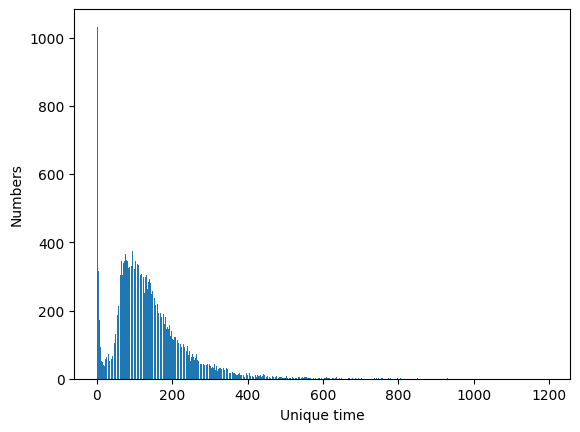

In [6]:
plt.figure()
plt.bar(time_count.keys(), time_count.values())
plt.ylabel('Numbers')
plt.xlabel('Unique time')
plt.show()

In [16]:
def process_chartevents(filename):
    df = pd.read_csv(filename, low_memory=False, 
            names=['PatientID','RecordID', 'Parameter', 'Value', 'Euom', 'Time'], sep='\t')
    df = df.dropna(axis=0, subset=['Value'])
    df['Time'] = df.Time.apply(to_timestamp)
    df.sort_values(["RecordID", "Time"], ascending=True, inplace=True)

    return df

In [18]:
df_ts = process_chartevents('../mimicdata/biomarks.csv')

### Noteevents可视化

In [3]:
df_text = pd.read_csv(datapath + text_data + '.csv',low_memory=False)
df_text.dropna(inplace=True)
df_text['RecordID'] = df_text['RecordID'].apply(lambda x: int(x))

In [4]:
df_text.head()

,RecordID,PatientID,Time,Text
0,100001,58526,4660773120,11:12 AM CHEST (PA & LAT) ...
1,100003,54610,5689447200,Sinus rhythm Prolonged QT interval is nonspeci...
2,100006,9895,4363120800,Sinus tachycardia Left axis deviation -\nanter...
3,100007,23018,5530212000,Sinus rhythm Atrial premature complex Consider...
4,100009,533,6070644000,"Sinus bradycardia, Left atrial abnormality, ..."


In [5]:
df_text['docu_len'] = df_text.Text.apply(lambda x: len(x.split('\n')))

In [6]:
# 统计每篇报告有多少句话
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained("emilyalsentzer/Bio_Discharge_Summary_BERT")
seq_len = []
doc_tokens = []
def func2(x):
    global sql_len, doc_tokens
    x = x.split('\n')
    length = len(x)
    number = 0
    for i in range(length):
        tokens = tokenizer.encode(x[i])
        tmp_len  = len(tokens)
        seq_len.append(tmp_len)
        number += tmp_len
    doc_tokens.append(number)

In [9]:
note_train = df_text.iloc[train]
note_val = df_text.iloc[val]
note_test = df_text.iloc[test]
for note_tmp in [note_train, note_val, note_test]:
    seq_len = []
    doc_tokens = []
    for index, df_tmp in note_tmp.iterrows():
        func2(df_tmp.Text)
    for m in [note_tmp.docu_len, seq_len, doc_tokens]:
        print(np.mean(m), np.std(m))


134.80815014336605 152.28598060357655
22.821080246495825 32.665163800704455
3076.4676123034146 3588.7338059327067
135.03596559812354 157.06391866681602
22.813008436057924 32.61183650036094
3080.5766223612195 3704.3533669551684
128.11497849041845 145.56012429050233
22.764324307823806 32.685310751625515
2916.4509190457566 3400.634186356055


In [10]:
for m in [df_text.docu_len, seq_len, doc_tokens]:
    print(np.mean(m), np.std(m))
    # print(min(df_text['docu_len']), max(df_text['docu_len']))
    # print(min(seq_len), max(seq_len))

134.4803423479756 152.1906688721035
22.764324307823806 32.685310751625515
2916.4509190457566 3400.634186356055


(0, 50]        5662
(50, 100]     22707
(100, 150]    15255
(150, 200]     5423
(200, 250]     1491
(250, 300]      389
(300, 350]      135
(350, 400]       55
(400, 450]       21
(450, 500]        5
(500, 550]        3
(550, 600]        1
(600, 650]        2
(650, 700]        1
(700, 750]        0
(750, 800]        0
(800, 850]        0
(850, 900]        0
(900, 950]        0
dtype: int64


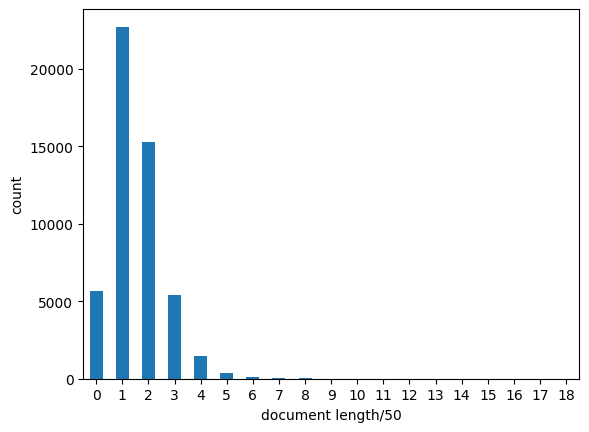

In [37]:
s = pd.cut(df_text.docu_len.values, bins=[i for i in range(0, 1000, 50)])
print(s.value_counts())
values = s.value_counts().values
df = pd.DataFrame(values)
df.plot(kind='bar', legend=False)
plt.xticks(rotation=0)
plt.ylabel('count')
plt.xlabel('document length/50')
plt.show()

(0, 50]       4552209
(50, 100]      364543
(100, 150]     141945
(150, 200]      72662
(200, 250]      39630
(250, 300]      22875
(300, 350]      13706
(350, 400]       8743
(400, 450]       5704
dtype: int64


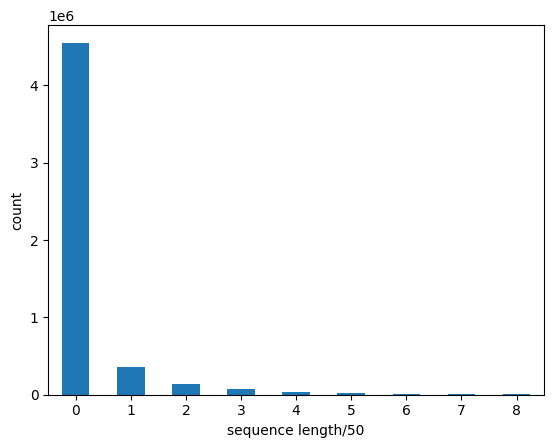

In [38]:
s = pd.cut(seq_len, bins=[i for i in range(0, 500, 50)])
print(s.value_counts())
values = s.value_counts().values
df = pd.DataFrame(values)
df.plot(kind='bar', legend=False)
plt.xticks(rotation=0)
plt.ylabel('count')
plt.xlabel('sequence length/50')
plt.show()

In [4]:
df_note = pd.read_csv(datapath + 'rawdata/Noteevents.csv')

In [5]:
df_note.head()

,PatientID,RecordID,Text,Time,category
0,22532,167853.0,Admission Date: [**2151-7-16**] Dischar...,5730400800,Discharge_summary
1,13702,107527.0,Admission Date: [**2118-6-2**] Discharg...,4684615200,Discharge_summary
2,13702,167118.0,Admission Date: [**2119-5-4**] D...,4714423200,Discharge_summary
3,13702,196489.0,Admission Date: [**2124-7-21**] ...,4879620000,Discharge_summary
4,26880,135453.0,Admission Date: [**2162-3-3**] D...,6066151200,Discharge_summary


{'Case Management ': 619, 'Consult': 50, 'Discharge_summary': 52726, 'ECG': 44185, 'Echo': 23585, 'General': 3170, 'Nursing': 9070, 'Nursing/other': 34890, 'Nutrition': 3167, 'Pharmacy': 68, 'Physician ': 8983, 'Radiology': 45526, 'Rehab Services': 2249, 'Respiratory ': 3986, 'Social Work': 1393}


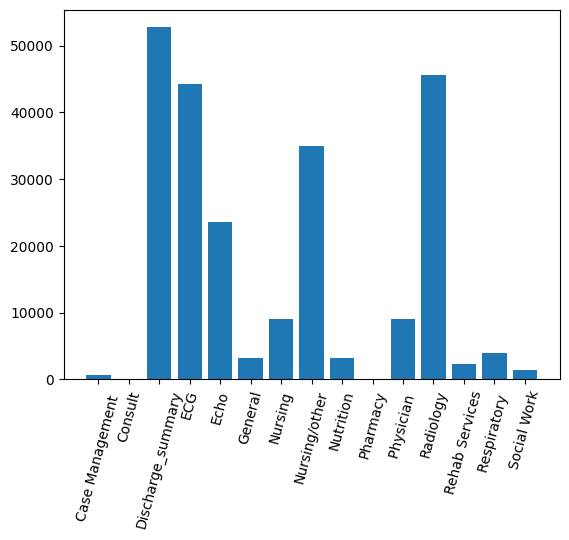

In [47]:
# 展示Noteevents每个category的数量
df_note_grouped = df_note.groupby('category')
cat_dic = {}
for (cat, df_tmp) in df_note_grouped:
    cat_dic[cat] = len(df_tmp.RecordID.unique())
print(cat_dic)
plt.figure()
plt.bar(cat_dic.keys(), cat_dic.values())
plt.xticks(rotation=75, fontsize=10)
plt.show()

In [19]:
tmppp = df_note[df_note.RecordID==173094.0]

In [20]:
tmppp

,PatientID,RecordID,Text,Time,category
34783,2513,173094.0,Admission Date: [**2148-10-13**] ...,5642704800,Discharge_summary
154660,2513,173094.0,Sinus bradycardia\nInferior axis\nLow limb lea...,5642532000,ECG
154661,2513,173094.0,Sinus rhythm\nRight axis deviation\nLow limb l...,5641927200,ECG
154662,2513,173094.0,Sinus rhythm\nSevere right axis deviation\nPos...,5641840800,ECG
154663,2513,173094.0,Sinus rhythm\nRight axis deviation\nPossible i...,5641840800,ECG
154664,2513,173094.0,Sinus rhythm\nMarked right axis deviation\nCon...,5641927200,ECG
790798,2513,173094.0,[**2148-10-13**] 8:56 AM\n CHEST (PA & LAT) ...,5641836960,Radiology
791078,2513,173094.0,[**2148-10-21**] 6:22 PM\n CHEST PORT. LINE PL...,5642562120,Radiology
799972,2513,173094.0,[**2148-10-22**] 9:19 AM\n CHEST (PA & LAT) ...,5642615940,Radiology
801704,2513,173094.0,PERSANTINE MIBI ...,5641891200,Radiology


In [30]:
print(tmppp.iloc[0, 2])

Admission Date:  [**2148-10-13**]              Discharge Date:   [**2148-10-23**]

Date of Birth:  [**2110-2-12**]             Sex:   M

Service: MEDICINE

Allergies:
Patient recorded as having No Known Allergies to Drugs

Attending:[**First Name3 (LF) 4765**]
Chief Complaint:
Chest pain

Major Surgical or Invasive Procedure:
Implantable Cardioverter Defibrillator (ICD) placed.


History of Present Illness:
38 M with 2V CABG [**5-30**], BiV pacer, dilated CM, CHF EF 20-25%
[**8-1**], p/w CP and NSVT, now with stable VS, CP-free.
Pt reports that fifteen minutes after participating in sexual
activity at ~3am, patient acquired a chest pain that ran across
both sides of his chest, with a predomination toward the right
side, with subsequent radiation down his right arm. The pain was
constant and was not resolving, which prompted a call to EMS.
Patient is unsure if the pain resolved, and even how, admits to
continued pain to [**Initials (NamePattern4) **] [**Last Name (NamePattern4) **] degr

In [5]:
# 展示每个category的报告样例
# Discharge_summary 出院报告
# ECG 心电图报告
# Echo 超声波报告
# Nursing 护士陪护笔记
df3 = df_note[df_note.category=="Radiology"]
df3_grouped = df3.groupby('RecordID')
cnt = 0
for (cat, df_tmp) in df3_grouped:
    '''
    if len(df_tmp) != 0:
        print("***************************************************")
        print("category:{}".format(cat))
        print(df_tmp.iloc[0, 2])
    '''
    if len(df_tmp) > 1:
        print(df_tmp.iloc[0, 2])
        print('+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++')
        if cnt == 1:
            break
        cnt += 1

[**2150-4-17**] 3:32 PM
 LIVER OR GALLBLADDER US (SINGLE ORGAN)                          Clip # [**Clip Number (Radiology) 6613**]
 Reason: ?portal vein thrombosis, ?tapable ascites (please mark)
 ______________________________________________________________________________
 [**Hospital 2**] MEDICAL CONDITION:
  59 year old man with liver disease, portal hypertension, now worsening LFTs,
  vomiting
 REASON FOR THIS EXAMINATION:
  ?portal vein thrombosis, ?tapable ascites (please mark)
 ______________________________________________________________________________
 WET READ: GWp FRI [**2150-4-17**] 3:58 PM
  No tapable ascites
  PV patent with normal hepatopetal flow
 ______________________________________________________________________________
                                 FINAL REPORT
 INDICATION:  59-year-old man with liver disease and portal hypertension now
 with worsening LFTs, query portal vein thrombosis with tapable ascites for
 mark.

 COMPARISON:  [**2150-4-8**].

 LLIVE

### 多模态可行性
##### 两模态时间上是否对齐

In [19]:
# 统计每份报告记录于哪天
def time_summarize(df):
    df.sort_values('RecordID', ascending=True, inplace=True)
    df_grouped = df.groupby('RecordID')
    res = {}
    for group in df_grouped:
        recordId, df0 = group[0], group[1]
        length = len(df0)
        ave = sum(df0.Time) / length
        res[recordId] = ave / 86400   # 3600 * 24
    return res

In [22]:
sens_date = time_summarize(df_ts)
text_date = time_summarize(df_text)

In [23]:
# 病患ID两模态交集数
set1 = set(sens_date.keys())
set2 = set(text_date.keys())
set3 = set1 & set2
print("sensors:{0}, notes{1}, intersection:{2}".format(len(set1), len(set2), len(set3)))

sensors:57020, notes51151, intersection:51151


In [24]:
s_date = np.array([value for key, value in sens_date.items() if key in set3])
t_date = np.array([value for key, value in text_date.items() if key in set3])
s_norm = (s_date - np.min(s_date)) / (np.max(s_date) - np.min(s_date))
t_norm = (t_date - np.min(t_date)) / (np.max(t_date) - np.min(t_date))

In [25]:
# 随机挑选100份记录
thesize = len(s_norm)
indexs = np.arange(0, thesize, 1, dtype=np.int32)
np.random.shuffle(indexs)
indexs = indexs[:100]
s_norm = s_norm[indexs]
t_norm = t_norm[indexs]

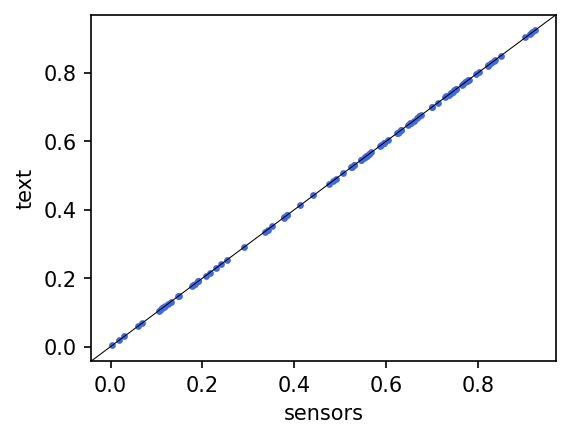

In [27]:
fig, ax = plt.subplots(1, 1,figsize=(4,3),dpi=150)
ax.plot((0, 1), (0, 1), transform=ax.transAxes, ls='-',c='k', linewidth=0.5)
ax.scatter(s_norm, t_norm, s=5, c='royalblue', marker='o')
plt.ylabel('text')
plt.xlabel('sensors')
plt.show()

In [6]:
data = np.load('../Multi_data/P18_Discharge_summary/PTdict_list.npy', allow_pickle=True)

In [10]:
a = data[0]['arr']

In [2]:
df = pd.read_csv('./PubMed_Timeline_Results_by_Year.csv')

In [3]:
df.head()

,Year,Count
0,2023,766
1,2022,1690
2,2021,1611
3,2020,1249
4,2019,1112


In [18]:
x = list(df.Year)[1:]
y = list(df.Count)[1:]

Text(0.5, 0, 'years')

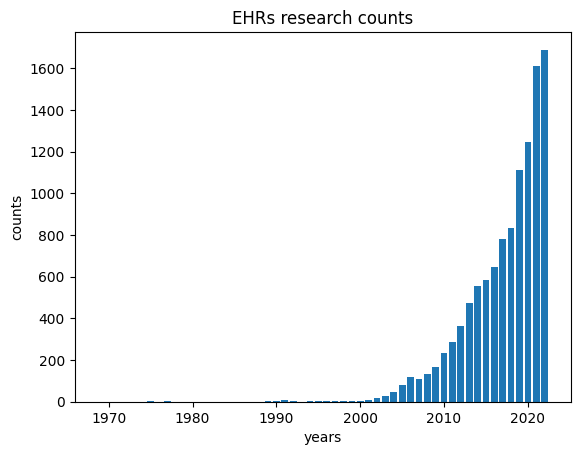

In [20]:
plt.bar(x, y)
plt.title('EHRs research counts')
plt.ylabel('counts')
plt.xlabel('years')